The system of partial differential equations for the Euler fluid dynamics state as follows in one spatial dimension:

$$
(1)\:\:\frac{\partial\rho}{\partial t}+\frac{\partial j}{\partial x}=0,
$$

$$
(2)\:\:\frac{\partial j}{\partial t}+\frac{\partial\left(p+\frac{1}{\rho}j^{2}\right)}{\partial x}=0,
$$

$$
(3)\:\:\frac{\partial e}{\partial t}+\frac{\partial\left[\frac{1}{\rho}j\left(e+p\right)\right]}{\partial x}=0,
$$

where $\rho$ is the density of the fluid, $p$ is the pressure, $u$ the velocity and $e$ the total energy density (total energy per unit volume). The quantity $j\equiv\rho u$ can be understood as the momentum density, which is a conservation variable, thus (2) be seen as the conservation of $j$, (1) as the mass conservation and (3) as the energy conservation. On the other hand, the equation of state (4) that relates the pressure with the rest of variables for a perfect gas, is defined as follows:

$$
(4)\:\:p=(\gamma-1)\left(e-\frac{1}{2}\frac{j^{2}}{\rho}\right).
$$

Thus, our variables will be $\textbf{U}=(\rho,j,e)$ and the problem will be solved for:

$$
t\in[0,1]\:\:\:and\:\:\:x\in[0,1],
$$

with the following initial conditions:

$$ \text{Initial conditions ($t=0$)}=  \left\{
\begin{array}{ll}
      \rho_{0}:\:\rho=1 & \text{for all $x$} \\
      u_{0}:\:u=0.9 & \text{if $x\leq 0.5$ and $u=0$ else} \\
      j_{0}:\:j=0.9 & \text{if $x\leq 0.5$ and $j=0$ else} \\
      p_{0}:\:p=1 & \text{if $x\leq 0.5$ and $p=10$ else} \\
      E_{0}:\:E=\frac{1}{\gamma-1}+\frac{1}{2}0.9^{2} & \text{if $x\leq 0.5$ and $E=\frac{10}{\gamma-1}$ else} \\
\end{array} 
\right. $$ 

In [1]:
# We import needed packages

import numba as nb
import numpy as np

from pde import PDE, FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid, CartesianGrid, MemoryStorage, plot_kymograph, movie # Coming from py-pde, which is not the same than pypde!!!

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
nx = 100 # Number of partitions in space
nt = 100 # Number of partitions in time
tf = 1.5 # Final time
xf = 1 # Final point
dt = tf/nt # Temporal interval
gamma = 1.4 # Heat capacity ratio

# We define functional equations.

eq = PDE(
    {
        "rho": f"-get_x(gradient(j))",
        "j": f"-get_x(gradient((j ** 2)/rho + ({gamma}-1) * (e - 0.5 * (j ** 2)/rho)))",
        "e": f"-get_x(gradient((j/rho) * (e + ({gamma}-1) * (e-0.5 * (j ** 2)/rho))))",
    },
    user_funcs={"get_x": lambda arr: arr[0]},
)

In [3]:
# We try to solve:

# Initial state (Initial conditions, t = 0):

x = np.linspace(0, xf, nx)

ic_rho = lambda x: 1
ic_j = lambda x: 0.9*(x<=0.5) + 0*(x>0.5)
ic_e = lambda x: (1/(gamma-1) + (0.9 ** 2)/2)*(x<=0.5) + (10/(gamma - 1))*(x>0.5)

# Defining grid:
grid = UnitGrid([nx])
#grid = CartesianGrid([[0, xf]], [nx], periodic = False) # The cartesian grid seems to not work with systems of equations...

rho = ScalarField(grid, ic_rho(x))
j = ScalarField(grid, ic_j(x))
e = ScalarField(grid, ic_e(x))

# Defining state
state = FieldCollection([rho, j, e])

# Simulation
storage = MemoryStorage()
sol = eq.solve(state, t_range = tf, dt = dt, tracker = ["progress", storage.tracker(dt)])

/home/netzuel/.local/lib/python3.8/site-packages/pde/tools/output.py:60: UserWarning: `tqdm` package is not available. Progress will be indicated by dots.
  warnings.warn(
.......

In [4]:
# We export the evolution in time of the variables:

times = []
rho_evolved = []
j_evolved = []
e_evolved = []

for time, field in storage.items():
    times.append(time)
    rho_evolved.append(field[0].data)
    j_evolved.append(field[1].data)
    e_evolved.append(field[2].data)

times = np.array(times) # Shape (nt,)
rho_evolved = np.array(rho_evolved) # Shape (nt, nx)
j_evolved = np.array(j_evolved) # Shape (nt, nx)
e_evolved = np.array(e_evolved) # Shape (nt, nx)

In [5]:
# Let's try to make some 3D plots...

X, T = np.meshgrid(x, times)

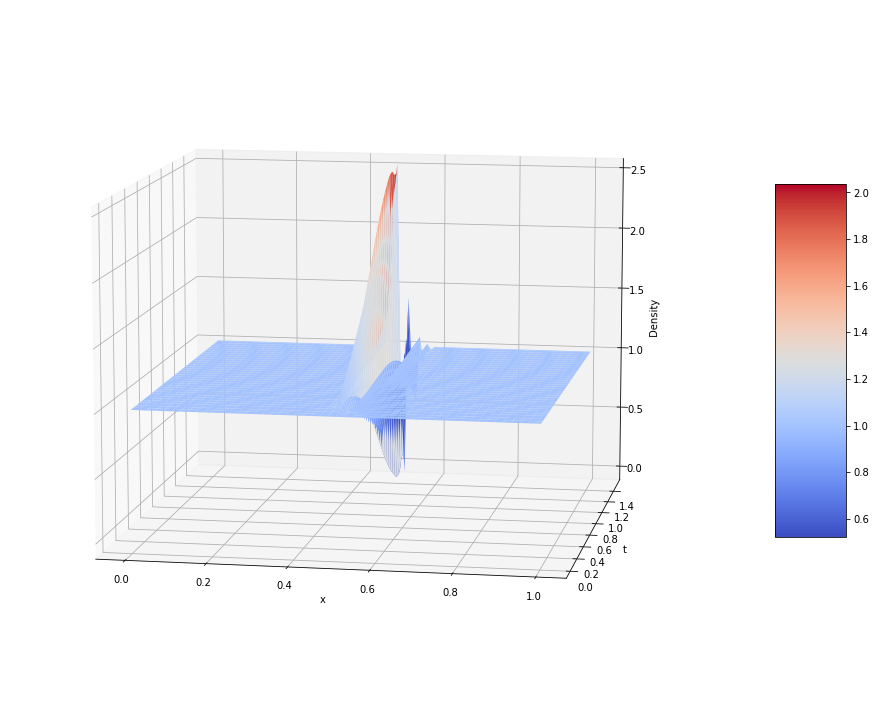

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, rho_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10, azim = 280)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Density")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.savefig("Density_3D.png")
plt.show()

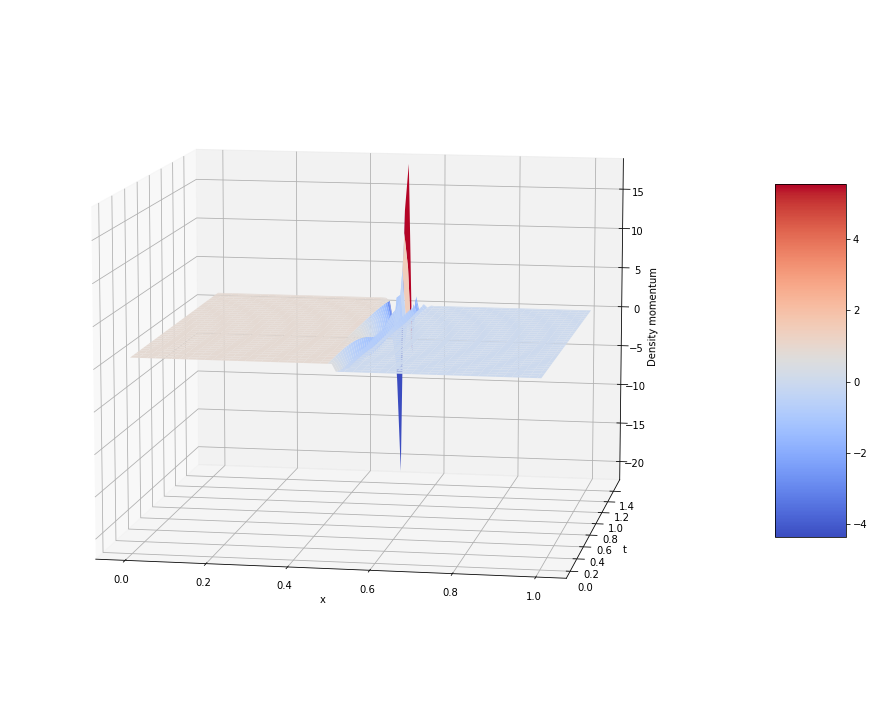

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, j_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10., azim = 280)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Density momentum")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.savefig("j_3D.png")
plt.show()

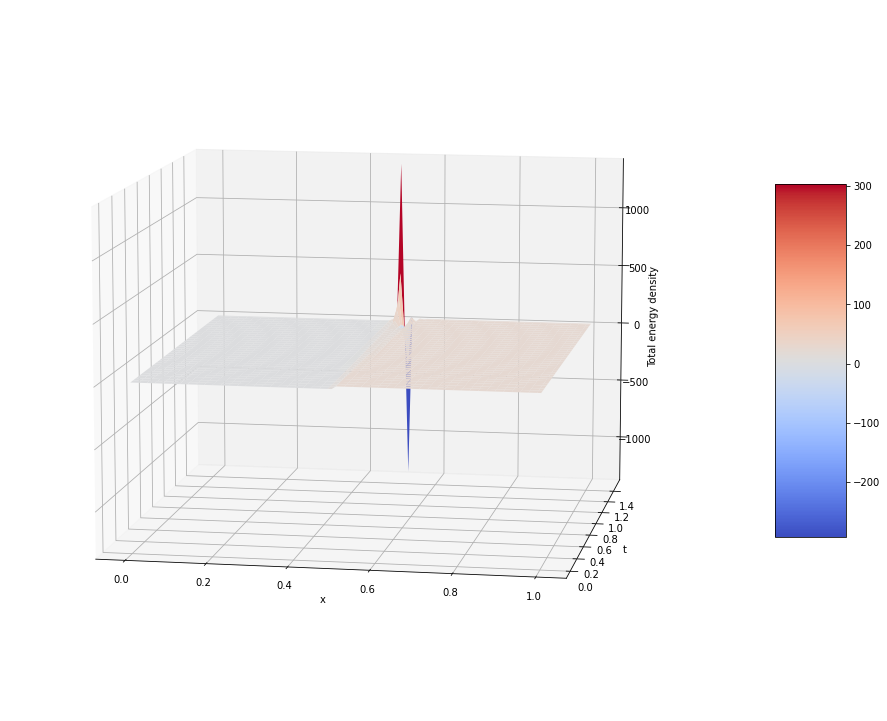

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_size_inches(22, 13)
surf = ax.plot_surface(X, T, e_evolved, cmap = cm.coolwarm, linewidth = 0, antialiased = True)
ax.view_init(elev = 10., azim = 280)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Total energy density")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.savefig("e_3D.png")
plt.show()

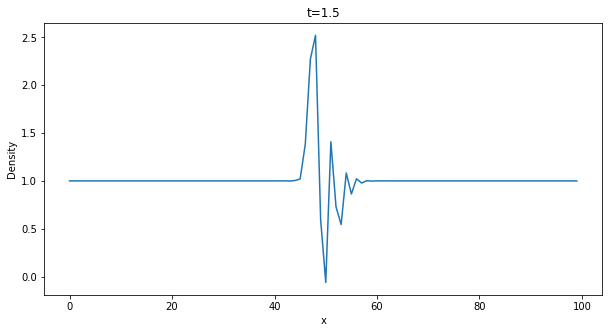

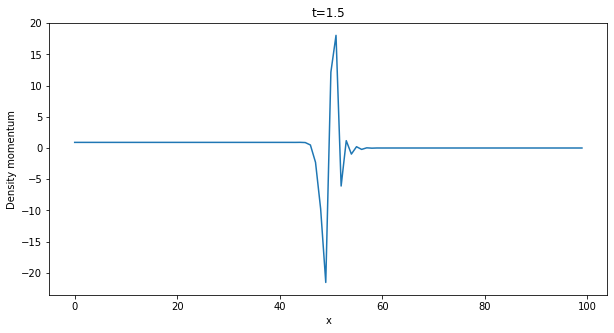

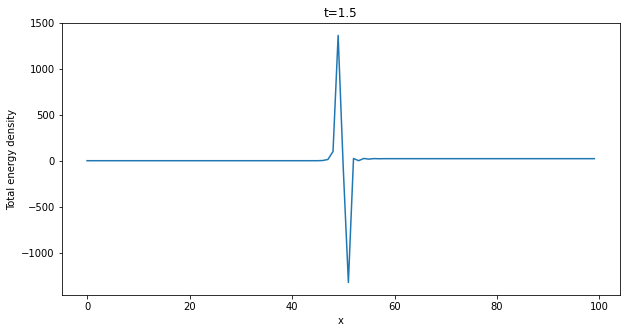

In [10]:
plt.plot(rho_evolved[rho_evolved.shape[0]-1,:])
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel("x")
plt.ylabel("Density")
plt.title("t=1.5")
plt.savefig("rho_t_1_5.png")
plt.show()

plt.plot(j_evolved[j_evolved.shape[0]-1,:])
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel("x")
plt.ylabel("Density momentum")
plt.title("t=1.5")
plt.savefig("j_t_1_5.png")
plt.show()

plt.plot(e_evolved[e_evolved.shape[0]-1,:])
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel("x")
plt.ylabel("Total energy density")
plt.title("t=1.5")
plt.savefig("e_t_1_5.png")
plt.show()